# Assignment 6

## About

This week we will be classifying flowers using quantum computers.

## Exercises

### 1) Install Qiskit Machine Learning

This is a good place to start:

https://qiskit.org/ecosystem/machine-learning/getting_started.html

### Imports

In [1]:
#Qiskit & qiskit_machine_learning
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.algorithms.optimizers import COBYLA, ADAM, SPSA

#Import warnings filter
from warnings import simplefilter

#Ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#Random generator seed
algorithm_globals.random_seed = 123

#Some other libs
import numpy as np
from matplotlib import pyplot as plt
import time

#We'll be using this when watching our classifier learn
from IPython.display import clear_output

ModuleNotFoundError: No module named 'qiskit_machine_learning'

### 2) Load the Iris dataset

Create a function <i>loadDataset(csvfile)</i> that loads the dataset:

Operations:
- Extract feauture names
- Extract flower names
- Convert targets to a binary representation

Returns:
- data : np.array of all feauture values (floats)
- features : np.array of all feauture names (strings)
- labels : np.array of all flower names (strings)

In [2]:
def loadDataset(csvfile):

    #Load csv data
    loaded = np.loadtxt(csvfile, delimiter=",", dtype=str)

    #Split raw into to features and data
    features, data = loaded[0], np.delete(loaded, 0,0)

    #Get unique names
    labels = np.unique(data[:,-1])

    #Replace names with values (0-2)
    for idx, name in enumerate(labels):
        data[data == name] = idx

    #To float
    data = data.astype(float)
    
    return data, features, labels

#Load data, features and label names
data, feature_names, flower_names = loadDataset("iris.csv")

FileNotFoundError: iris.csv not found.

### 3) Split dataset into train/validation

Create a function <i>GetTrainVal(data, labels, split)</i> that splits the dataset in two:

Returns:
- train_X : np.array with features for training
- train_y : np.array with labels for training
- val_X : np.array with features for validation
- val_y : np.array with labels for validation

In [3]:
def GetTrainVal(data, labels, split):

    items = len(labels)     #Train size
    sel = int(items*split)  #Val size
    
    #Indices
    ind = np.random.choice(items, items-sel, replace=False)
    
    #Data
    val_X = data[ind]
    val_y = labels[ind]
    train_X = np.delete(data, ind, 0)
    train_y = np.delete(labels, ind)

    return train_X, train_y, val_X, val_y

#Split Iris dataset: Train = 80%   Validation = 20%
train_X, train_y, val_X, val_y = GetTrainVal(data[:,0:4], data[:,-1].astype('int'), .8)
num_features = train_X.shape[1]

### 4) Scatter plot the flowers

Create a function <i>IrisPlot(f_Idx1, f_Idx2)</i> that scatter plots all flower features given by indexes <i>f_Idx1</i> and <i>f_Idx2</i>.

Annotate your plot properly.

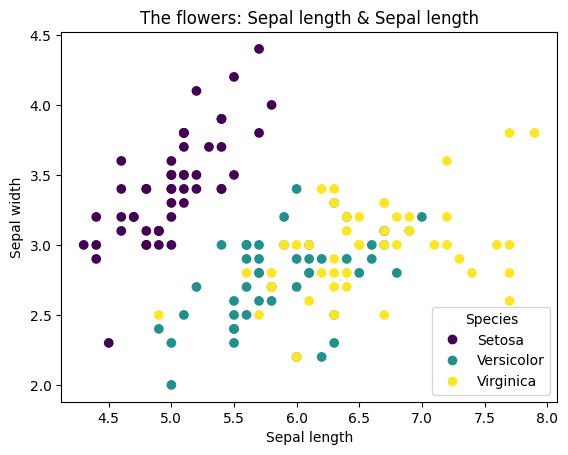

In [4]:
def IrisPlot(f_Idx1, f_Idx2):

    #Make plot
    scatter = plt.scatter(data[:, f_Idx1], data[:, f_Idx2], c=data[:, -1])
    plt.legend(
        scatter.legend_elements()[0], flower_names, loc="lower right", title=feature_names[-1]
    )
    plt.title("The flowers: " + feature_names[f_Idx1] +" & " + feature_names[f_Idx1])
    plt.xlabel(feature_names[f_Idx1])
    plt.ylabel(feature_names[f_Idx2])
    plt.show()


#Pick some features
f1 = np.where(feature_names == "Sepal length")[0][0]
f2 = np.where(feature_names == "Sepal width")[0][0]

#Test function
IrisPlot(f1,f2)

### 5) Mapping features

We need a way to encode the features of the flowers on to a circuit. There are several ways this can be done, but we'll start by utilizing Qiskit's built in feature mapper <i>ZZFeatureMap</i>.

You can find the documentation here: https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html

- Create a variable <i>encoder1 = ZZFeatureMap(...)</i>
- Draw the circuit
- Play around with parameters <i>reps</i> and <i>entanglement</i> and make sure you understand what's going on.
- What kind of encoding is this?

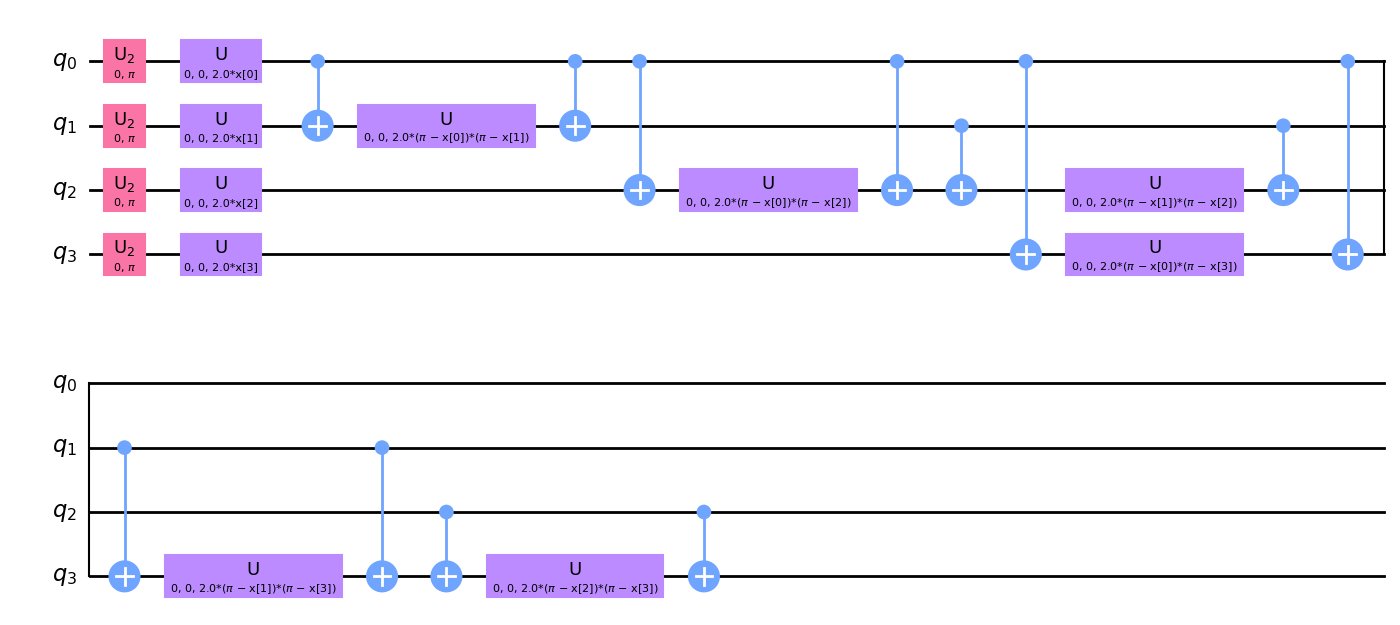

In [5]:
#Use Qiskit's built in feature mapper:
encoder1 = ZZFeatureMap(feature_dimension=num_features, reps=1, entanglement='full')
encoder1.decompose().decompose().draw(output="mpl", fold=20)

### 6) Ansatz

In quantum computing, a parameterized circuit is often referred to as an ansatz. The individual rotations in our ansatz will serve as tunable weights when we run our optimization algorithm.

Again, we'll start by using a Qiskit built in circuit: RealAmplitudes https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html

- Create a variable <i>ansatz = RealAmplitudes(...)</i>
- Draw the circuit
- Play around with parameters <i>reps</i> and <i>entanglement</i> and make sure you understand what's going on.

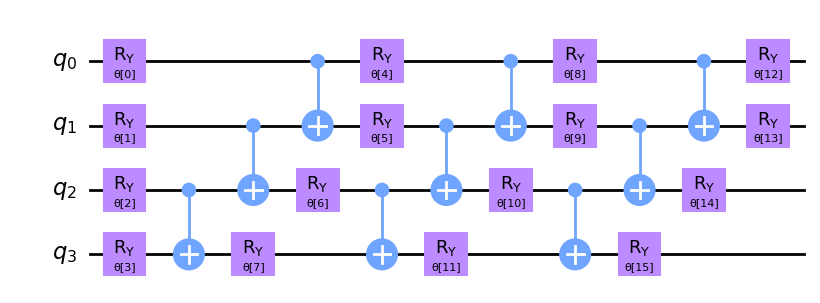

In [6]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

### 7) Variational Quantum Classifier

In this exercise we will be using Qiskit's VQC. The variational quantum classifier (VQC) is a variational algorithm where the measured bitstrings are interpreted as the output of a classifier. 

Have a look here: https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html

We need to specify how we want to sample and optimize our classifier. Again, we'll be using some classes available with Qiskit Machine Learning:

https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html

https://qiskit.org/documentation/stubs/qiskit.primitives.Sampler.html

- What is the purpose of <i>sampler</i>?
- What is the default loss function used in Qiskit's VQC?

In [7]:
#Optimizer
optimizer = COBYLA(maxiter=40)

#Sampler
sampler = Sampler()

#Keep track of objective function values
objective_func_vals = []

### 8) Visualize training

Using Qiskit's VQC we can specify a callback routine to run for each iteration of the optimization process.

Make sure you understand what is being plotted and annotate properly.

In [8]:
def TrainingCallback(weights, obj_func_eval):
    
    #Clear output
    clear_output(wait=True)

    #Append values
    objective_func_vals.append(obj_func_eval)

    #Annotations
    plt.title("Cross-entropy loss against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Cross-entropy loss")

    #Display
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### 9) Train

Ok, we're ready to train our classifier.

- Create <i>vqc1 = VQC(...)</i>
- Run <i>vqc1.fit(...)</i>
- Is the live-plotting working?
- Is the classifier fitting to your dataset?

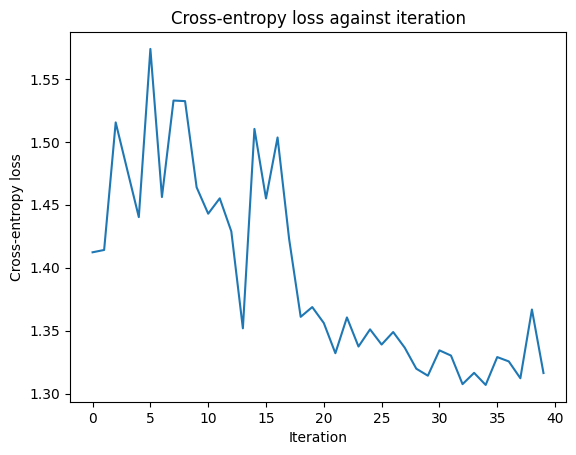

Training time: 103 seconds


In [9]:
vqc1 = VQC(
    sampler=sampler,
    feature_map=encoder1,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=TrainingCallback
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc1.fit(train_X, train_y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

### 10) Scoring

- Run <i>vqc1.score(...)</i>
- What is the score you got representing?
- Was this a good score?
- What is the purpose of "Hold-out data" in machine learning?

In [10]:
test_score = vqc1.score(val_X, val_y)
print(f"VQC1 on the validation dataset:     {test_score:.2f}")

VQC1 on the validation dataset:     0.57


### 11) Build your own decoder

Create a circuit <i>encoder2 = QuantumCircuit(...)</i> that maps each individual feature of your dataset to a qubit.

Use angle encoding. Draw your circuit.

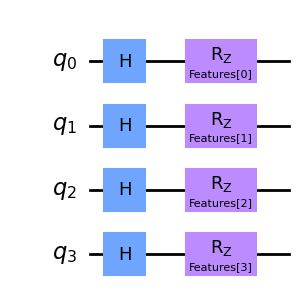

In [11]:
encoder2 = QuantumCircuit(num_features)

#Vector for encoding the features
ip = ParameterVector('Features',num_features) 

for i in range(num_features):
    encoder2.h(i)
    encoder2.rz(ip[i], i)

encoder2.draw('mpl')

### 12) Train and test using your new encoder

- Create <i>vqc2 = VQC(...)</i> using your custom built encoder.
- Train and score <i>vqc2</i>
- Compare the results to <i>vqc1</i>
- Did you just create an encoder that performed better than Qiskit's?
- Wow, well done. Does your encoder scale as good as <i>ZZFeatureMap</i>?

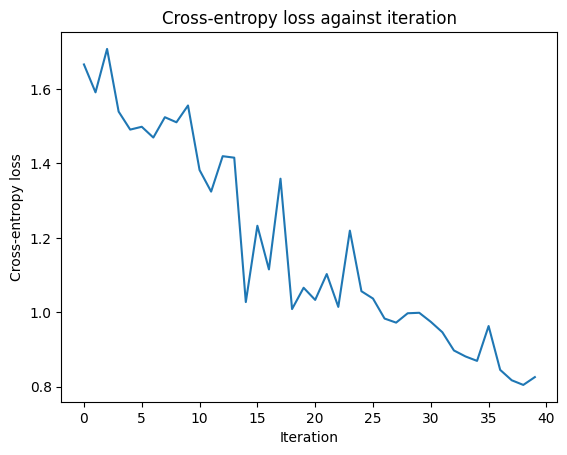

Training time: 49 seconds
VQC2 on the validation dataset:     0.93


In [12]:
vqc2 = VQC(
    sampler=sampler,
    feature_map=encoder2,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=TrainingCallback
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc2.fit(train_X, train_y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")
test_score = vqc2.score(val_X, val_y)
print(f"VQC2 on the validation dataset:     {test_score:.2f}")

### 13) Normalization

The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.

For a quantum circuit using rotation gates... What is an appropriate range?

- Normalize your datasets to an appropriate range

In [14]:
#Normalize array between values t_min and t_max
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

#Normalize array between -π and π. Skip label column.
def piNorm(arr):
    
    #Data dimensions
    shp = arr.shape

    #Don't normalize labels
    d = np.array(arr[:,-1],dtype=float).reshape(shp[0],1)
    
    #Normalize everything else, column by column
    for i in reversed(range(shp[1]-1)):
        d = np.insert(d, 0, normalize(arr[:,i], -np.pi,np.pi), axis=1)
    
    return d

data = piNorm(data)

#Split Iris dataset: Train = 80%   Validation = 20%
train_X, train_y, val_X, val_y = GetTrainVal(data[:,0:4], data[:,-1].astype('int'), .8)
num_features = train_X.shape[1]

### 14) More testing

Using your normalized datasets:

- Increase the number of iterations in your optimizer
- Train, score, compare....

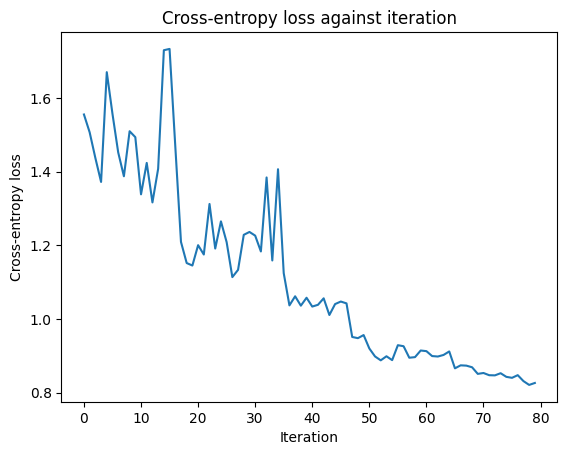

Training time: 98 seconds
VQC3 on the normalized validation dataset:     0.77


In [16]:
optimizer = COBYLA(maxiter=80)

vqc3 = VQC(
    sampler=sampler,
    feature_map=encoder2,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=TrainingCallback
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc3.fit(train_X, train_y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")
test_score = vqc3.score(val_X, val_y)
print(f"VQC3 on the normalized validation dataset:     {test_score:.2f}")